In [1]:
%pip install pymoo

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 352.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 315.1 kB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 685.8 kB/s eta 0:00:00:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 567.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 1.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     41 |             - |             -
     2 |      400 |    100 |  0.0083352925 |             f
     3 |      600 |    196 |  0.0047967956 |         nadir
     4 |      800 |    200 |  0.0034156736 |             f
     5 |     1000 |    200 |  0.0012092224 |             f
     6 |     1200 |    200 |  0.0019047326 |             f
     7 |     1400 |    200 |  0.0022010282 |             f
     8 |     1600 |    200 |  0.0024156747 |             f
     9 |     1800 |    200 |  0.0026183760 |             f
    10 |     2000 |    200 |  0.0008980088 |             f
    11 |     2200 |    200 |  0.0014152488 |             f
    12 |     2400 |    200 |  0.0018469143 |             f
    13 |     2600 |    200 |  0.0021088473 |             f
    14 |     2800 |    200 |  0.0020670408 |             f
    15 |     3000 |    200 |  0.0021440847 |             f
    16 |     3200 |    200 |  0.0022672411 |            

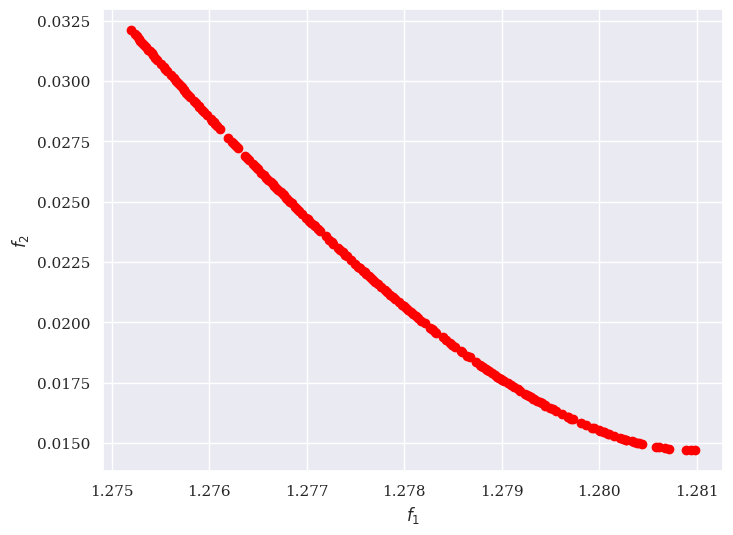

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

sns.set()


class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=1,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([0]),
                         xu=np.array([1]),
                         elementwise_evaluation=True)

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = (-0.0957*x**4) + (0.2051*x**3) - (0.1541*x**2) + (0.0581*x) + 1.2752
        f2 = (0.784*x**4) - (1.7531*x**3) + (1.2806*x**2) - (0.2712*x) + 0.0321
#         f2 = (-0.0053*x**4) + (0.0229*x**3) - (0.0021*x**2) + (0.0248*x) + (0.0321)
        out["F"] = np.column_stack([f1, f2])


problem = MyProblem()

algorithm = NSGA2(pop_size=200)

res = minimize(problem,
               algorithm,
               ("n_gen", 200),
               verbose=True,
               seed=1)

plot = Scatter()
plot.add(res.F, color="red")
plot.show()

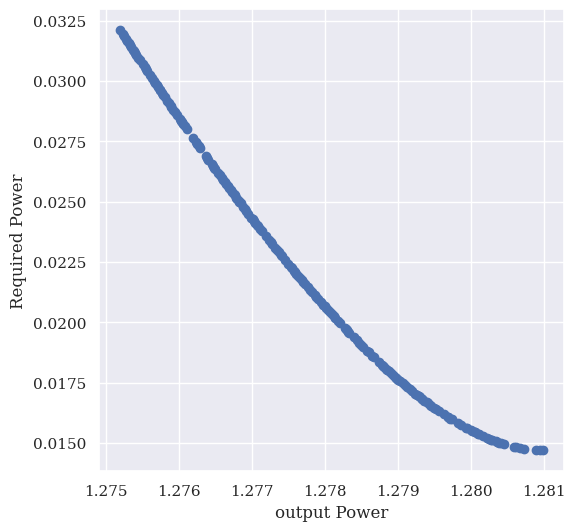

In [ ]:
plt.figure(figsize = (6, 6))
plt.scatter(res.F[:, 0], res.F[:, 1])
plt.xlabel("output Power")
plt.ylabel("Required Power")
# plt.savefig("output.png", dpi = 600)

Simulated rounds: 2000
Energy (J) - mean: 1.2375, median: 1.1901, std: 0.1568, 95p: 1.5225


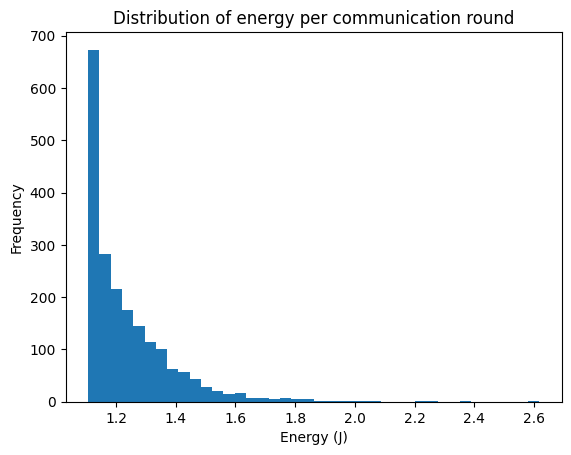


Worst-case (max E) breakdown: 2.6172533061847547 {'E_tx': 1.2437333124498116, 'E_rx': 0.3731199937349435, 'E_comp': 1.0, 'E_overhead': 0.0004, 'r': 1.2560317576624074, 'p_loss': 0.20384178672273887}
Median-case breakdown: 1.1901648248253205 {'E_tx': 0.14597294217332343, 'E_rx': 0.04379188265199702, 'E_comp': 1.0, 'E_overhead': 0.0004, 'r': 1.1091696136653677, 'p_loss': 0.09842463435741382}


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Parameters (edit as needed) ----------
S = 200_000            # bytes to send (e.g., gradient size)
S_rx = 100_000         # bytes to receive
P_tx = 0.05            # W
P_rx = 0.03            # W
P_cpu = 0.2            # W
P_idle = 0.002         # W
t_comp = 5.0           # s
p_loss_base = 0.05     # base packet loss probability (can be function of b)
handshake = 0.2        # s per handshake
M = 800 * 1024         # available memory in bytes (e.g., 800 KB)
S_chunk_max = M        # chunk size (<=M)
num_sim = 2000         # Monte Carlo runs

# Bandwidth model: sample from a distribution (B/s)
# Example: lognormal so values are > 0. Adjust mean to your environment
# Max bandwidth cap (1 Mbps):
max_bps = 1_000_000 / 8.0   # convert 1 Mbps -> bytes/s = 125000
# We'll build bandwidth samples in B/s
mu = np.log(125000 * 0.6)    # change 0.6 to shift median
sigma = 0.6
bw_samples = np.random.lognormal(mean=mu, sigma=sigma, size=num_sim)
bw_samples = np.clip(bw_samples, 1000, max_bps)  # lower bound 1KB/s, upper cap

# Optional: make packet loss increase when bandwidth is low
def p_loss_from_b(b):
    # simple mapping: lower bandwidth -> slightly higher loss
    # b in B/s; normalize to [0,1]
    frac = b / max_bps
    return np.clip(0.02 + (1 - frac) * 0.2, 0.01, 0.6)

# Energy calculation per round (handles chunking)
def energy_for_one_round(S, S_rx, b, P_tx, P_rx, P_cpu, P_idle, t_comp, handshake, S_chunk_max):
    # retransmission factor
    p_loss = p_loss_from_b(b)
    r = 1.0 / (1.0 - p_loss)
    # chunking
    if S <= S_chunk_max:
        t_tx = S / b
        E_tx = P_tx * t_tx * r
        overhead_tx = handshake * P_idle
    else:
        # split into chunks (last chunk can be smaller)
        chunks = int(np.ceil(S / S_chunk_max))
        E_tx = 0.0
        overhead_tx = 0.0
        bytes_left = S
        for _ in range(chunks):
            send_bytes = min(bytes_left, S_chunk_max)
            t_tx_j = send_bytes / b
            E_tx += P_tx * t_tx_j * r
            overhead_tx += P_idle * handshake
            bytes_left -= send_bytes
    # receive (assume fits in memory, else similar chunking could be applied)
    t_rx = S_rx / b
    E_rx = P_rx * t_rx * r
    # compute
    E_comp = P_cpu * t_comp
    # idle handshake already included as overhead_tx; add any listening time if needed
    E_total = E_tx + E_rx + E_comp + overhead_tx
    return E_total, {
        'E_tx': E_tx, 'E_rx': E_rx, 'E_comp': E_comp, 'E_overhead': overhead_tx, 'r': r, 'p_loss': p_loss
    }

# Monte Carlo
energies = []
breakdown = []
for b in bw_samples:
    E, info = energy_for_one_round(S, S_rx, b, P_tx, P_rx, P_cpu, P_idle, t_comp, handshake, S_chunk_max)
    energies.append(E)
    breakdown.append(info)

energies = np.array(energies)
print("Simulated rounds:", num_sim)
print("Energy (J) - mean: {:.4f}, median: {:.4f}, std: {:.4f}, 95p: {:.4f}".format(
    energies.mean(), np.median(energies), energies.std(), np.percentile(energies,95)
))

# Optional: histogram
plt.hist(energies, bins=40)
plt.title("Distribution of energy per communication round")
plt.xlabel("Energy (J)")
plt.ylabel("Frequency")
plt.show()

# Print example breakdown for the worst-case and a median case
idx_max = np.argmax(energies)
idx_med = np.argsort(energies)[len(energies)//2]
print("\nWorst-case (max E) breakdown:", energies[idx_max], breakdown[idx_max])
print("Median-case breakdown:", energies[idx_med], breakdown[idx_med])
